<a href="https://colab.research.google.com/github/mauricioleng/ONS_Project/blob/main/Previsao_Carga_ONS_An%C3%A1lise_Explorat%C3%B3ria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de carga do SIN usando métodos de ML
##Parte 1 - Análise Exploratória

<img src='https://images.unsplash.com/photo-1473341304170-971dccb5ac1e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1470&q=80'>

Este estudo busca realizar previsões da carga do Sistema Integrado Nacional utilizando técnicas de Machine Learning e Deep Learning. As técnicas e premissas utilizadas nesses estudo são para fins educacionais, portanto serão adotadas simplificações nas modealgens afim de facilitar a didática.
As bases de dados utilizadas foram obtidas a partir do portal de dados abertos do Operador Nacional do Sistema (https://dados.ons.org.br/)

Devido a complexidade envolvida nas etapas de um projeto desse tipo envolvendo séries temporais, o estudo será segmentado em 3 partes. A primeira parte contempla a análise exploratória e tratamento de anomalias.

Embora a base utilizada não possua muitas features é necessário validar a integridade dos dados, bem como garantir a aderência a premissas estatísticas necessárias as etapas posteriores.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# funcao para realizar a montagem do dataframe com as bases de 2000 a 2021
def todos_anos_ons():
  df = pd.DataFrame()
  for ano in range(2000,2022):
    df_temp = pd.read_csv(f'https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_{ano}.csv', sep=';', 
                          parse_dates=['din_instante'], dtype={'id_subsistema': str, 'nom_subsistema': str})
    df = df.append(df_temp, ignore_index=True)
  return df

In [3]:
df_original = todos_anos_ons()

In [4]:
# cópia do DataFrame original afim de facilitar futuras manipulaçoes que necessitem ser refeitas 
df = df_original.copy()

In [5]:
df.head()

,id_subsistema,nom_subsistema,din_instante,val_cargaenergiamwmed
0,N,NORTE,2000-01-01,2243.512500
1,NE,NORDESTE,2000-01-01,4646.370833
2,S,SUL,2000-01-01,4800.650000
3,SE,SUDESTE,2000-01-01,19045.995833
4,N,NORTE,2000-01-02,2259.808333


Observando as primeiras linhas do arquivo é possível identificar a estrutura 
dos dados:
* id_subsistema: código interno relativo a cada subsistema
* nom_subsistema: nome de cada subsistema
* din_instante: data de cada mediçao
* val_cargaenergiamwmed: valor da carga diária

Portanto para calcularmos a carga do SIN será necessário somar a carga de todos os subsistemas em cada dia. 

In [6]:
# renomeando as colunas para nomes mais amigáveis
df.rename(columns={'din_instante':'data', 'val_cargaenergiamwmed':'carga'}, inplace=True)

In [7]:
df.shape

(32145, 4)

In [8]:
df.dtypes

id_subsistema             object
nom_subsistema            object
data              datetime64[ns]
carga                    float64
dtype: object

In [9]:
df.describe()

,carga
count,32096.000000
mean,13433.460763
std,11464.839997
min,1852.020833
25%,5625.631781
50%,8595.887687
75%,15703.568552
max,46700.404750


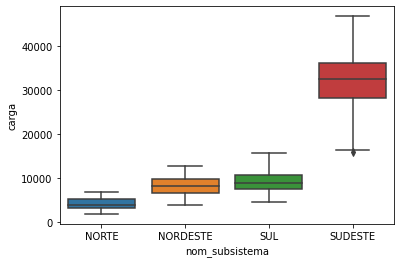

In [10]:
ax = sns.boxplot(x="nom_subsistema", y="carga", data=df)

Através das medidas descritivas e do boxplot pode-se perceber a aparente ausência de outliers em cada subsistema.

In [11]:
df['ano'] = pd.DatetimeIndex(df['data']).year

In [12]:
df.groupby(['ano','id_subsistema']).size().unstack()

id_subsistema,N,NE,S,SE
ano,,,,
2000,366,366,366,366
2001,365,365,365,365
2002,365,365,365,365
2003,365,365,365,365
2004,366,366,366,366
2005,365,365,365,365
2006,365,365,365,365
2007,365,365,365,365
2008,366,366,366,366


Pode-se perceber que não existe ausência de dias em nenhum ano ou submercado, porém com um olhar atento é possível perceber que o subsistema SUL possui um dia a mais que os demais em 2013. É preciso eliminar essa inconsistência.

In [13]:
df_sul_data = df[df['nom_subsistema']=='SUL'].data
df_sudeste_data = df[df['nom_subsistema']=='SUDESTE'].data
df_sul_data[~df_sul_data.isin(df_sudeste_data)]

19128   2013-02-02 00:00:01
Name: data, dtype: datetime64[ns]

In [14]:
index_to_drop = df[df['data']=='2013-02-02 00:00:01'].index
df.drop(index_to_drop, inplace=True)

In [15]:
df.isna().sum()

id_subsistema      0
nom_subsistema     0
data               0
carga             48
ano                0
dtype: int64

É possível identificar a ausência de dados de carga em 48 amostras. Observando no detalhe a seguir é possível perceber que trataram-se de falhas pontuais, além de uma falha mais extensa compreendida entre 05-04-2016 e 13-04-2016.

Levando em consideração a baixa quantidade de falhas e a natureza dos dados, optou-se por adotar a estratégia de preenchimento dos dados faltantes pelo último dado válido anterior em cada subsistema.

In [16]:
df[df.carga.isna()==True]

,id_subsistema,nom_subsistema,data,carga,ano
20333,N,NORTE,2013-12-01,NaN,2013
20334,NE,NORDESTE,2013-12-01,NaN,2013
20335,S,SUL,2013-12-01,NaN,2013
20336,SE,SUDESTE,2013-12-01,NaN,2013
20581,N,NORTE,2014-02-01,NaN,2014
20582,NE,NORDESTE,2014-02-01,NaN,2014
20583,S,SUL,2014-02-01,NaN,2014
20584,SE,SUDESTE,2014-02-01,NaN,2014
22309,N,NORTE,2015-04-09,NaN,2015
22310,NE,NORDESTE,2015-04-09,NaN,2015


In [17]:
df = df.groupby('id_subsistema').ffill().reset_index()

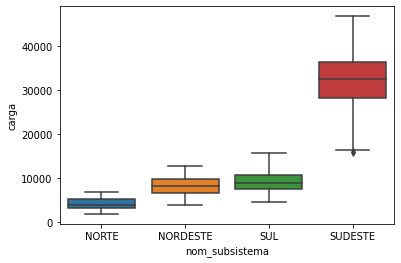

In [18]:
ax = sns.boxplot(x="nom_subsistema", y="carga", data=df)

Pelo boxplot anterior é possível perceber que não foram alterados de forma siginificativa aos principais indicadores estatísticos, tampouco foram gerados outliers pela inserção dos dados ausentes.

In [19]:
# agrupando os dados para o cálculo da carga do SIN
df_sin = df[['data','carga']].groupby(['data']).sum()

In [20]:
# verificando a distribuição quantitativa dos dados por submercado
print(df[df['nom_subsistema']=='NORTE'].count())
print(df[df['nom_subsistema']=='NORDESTE'].count())
print(df[df['nom_subsistema']=='SUDESTE'].count())
print(df[df['nom_subsistema']=='SUL'].count())

index             8036
nom_subsistema    8036
data              8036
carga             8036
ano               8036
dtype: int64
index             8036
nom_subsistema    8036
data              8036
carga             8036
ano               8036
dtype: int64
index             8036
nom_subsistema    8036
data              8036
carga             8036
ano               8036
dtype: int64
index             8036
nom_subsistema    8036
data              8036
carga             8036
ano               8036
dtype: int64


In [21]:
# devido a densidade de pontos, é recomendável reagrupar os dados por periodicidade mensal para facilitar a legibilidade nos gráficos
df_sub=[]
for subsistema in df['nom_subsistema'].unique():
  df_sub.append(df[df['nom_subsistema']==subsistema].set_index('data').resample('M').sum())
df_sin_m = df_sin.resample('M').sum()

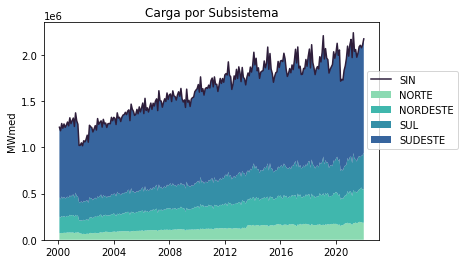

In [48]:
colors = sns.color_palette("mako_r")
plt.stackplot(df_sub[0].index, df_sub[0].carga, df_sub[1].carga, df_sub[2].carga, df_sub[3].carga, labels=df.nom_subsistema, colors=colors)
plt.plot(df_sub[0].index,df_sin_m['carga'], label='SIN', color=colors[5])
plt.legend(loc = "upper center", bbox_to_anchor=(1.1, 0.8), ncol=1)
plt.title('Carga por Subsistema')
plt.ylabel('MWmed')

plt.show()

Pelo gráfico é possível confirmar que a carga do SIN realmente é formada pelo somatório das cargas dos 4 subsistemas conforme o desejado.

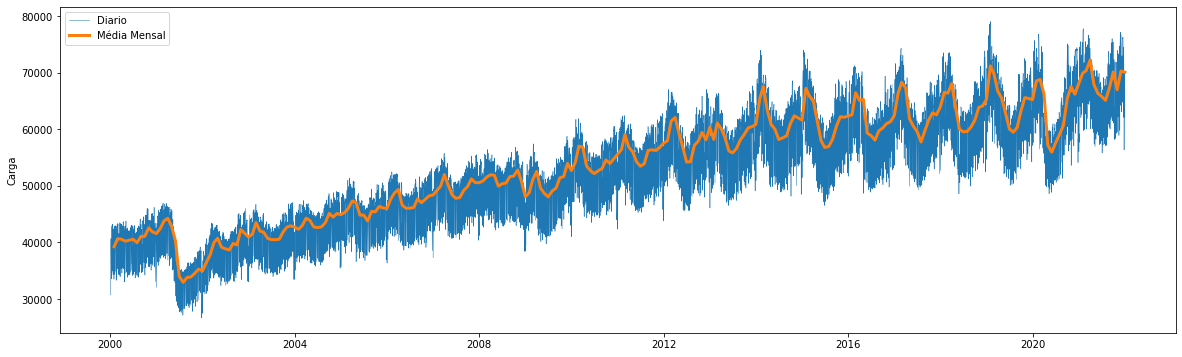

In [52]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df_sin, linestyle='-', linewidth=0.5, label='Diario')
ax.plot(df_sin.resample('M').mean(), linewidth=3, linestyle='-', label='Média Mensal')
ax.set_ylabel('Carga')
ax.legend();

É possível confirmar que a série não aparenta ter anomalias. Usa-se a média mensal afim de facilitar a visualização do comportamento padrão da grandeza, já que a série dispõe de uma densidade de pontos bastante elevada.



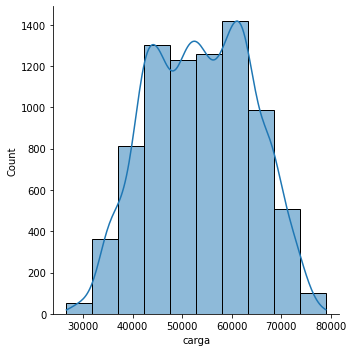

In [24]:
sns.displot(data=df_sin, x='carga', kde=True, bins=10);

Pelo histograma é possível perceber que a distribuição de carga do SIN se aproxima de uma distribuição normal e não aparenta ter outliers. Devido ao leve desvio para a direita do diagrama, pode ser necessária a aplicação de alguma transformação posterior no caso de algoritmos mais sensíveis a dados distribuídos não normalmente.

In [76]:
from scipy.stats import describe
describe(df_sin)


DescribeResult(nobs=8036, minmax=(array([26656.47499999]), array([79038.11275001])), mean=array([53754.3318423]), variance=array([1.05827947e+08]), skewness=array([-0.03347898]), kurtosis=array([-0.82015445]))

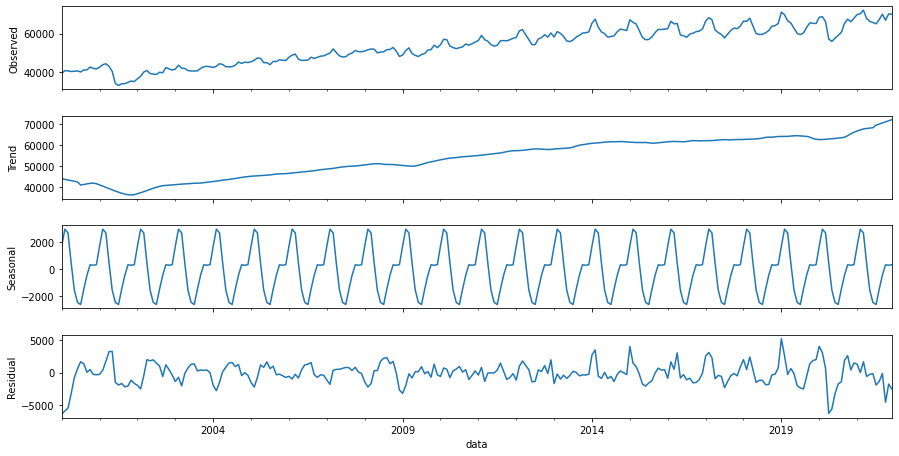

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_sin.resample('M').mean(), model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

Utilizando a decomposição sazonal presente na biblioteca statsmodel é possível perceber a presença de um comportamento sazonal, bem como uma tendência de crescimento. Apenas por esses dados já é possível inferir que a série não é estacionária, porém como essa característica é importante para modelos de regressão e previsão, vamos fazer o teste de Dickey Fuller para confirmar essa hipótese.

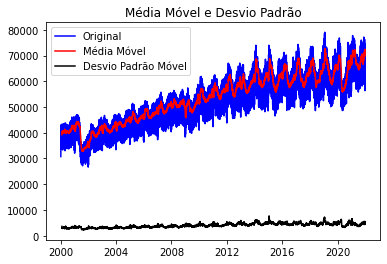

Resultados do teste Dickey Fuller
Test Statistics                  -1.888490
p-value                           0.337495
No. of lags used                 36.000000
Number of observations used    7999.000000
critical value (1%)              -3.431168
critical value (5%)              -2.861901
critical value (10%)             -2.566962
dtype: float64


In [28]:
from statsmodels.tsa.stattools import adfuller
# script adaptado de https://www.kdnuggets.com/2020/01/predict-electricity-consumption-time-series-analysis.html
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Média Móvel')
    plt.plot(rolstd, color='black', label = 'Desvio Padrão Móvel')
    plt.legend(loc='best')
    plt.title('Média Móvel e Desvio Padrão')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Resultados do teste Dickey Fuller")
    adft = adfuller(timeseries['carga'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output);
    
test_stationarity(df_sin)

Com o valor de p muito acima de 5% a hipótese inicial de que a série é estacionária é recusada. 

Como resultado tem-se uma base de dados limpa de outliers e valores nulos, pronta para ser utilizada em modelos de previsão. Importante apenas tratar as características de não normalidade e não estacionariedade de acordo com a necessidade de cada modelo, porém essa parte será tratada na parte 2 do estudo.

In [29]:
# exportando os dados tratados
from google.colab import drive

drive.mount('/content/drive/')
path = '/content/drive/My Drive/Colab Notebooks/Energia/Data/df_SIN.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_sin.to_csv(f)

Mounted at /content/drive/
